In [7]:
import xarray as xr 
import matplotlib.pyplot as plt
from pathlib import Path
import seawater as sw
import numpy as np
from tqdm import tqdm
from PIL import Image
import io

In [2]:
from dask.distributed import Client

In [12]:
data_path = '/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/'
experiment_name = 'INALT20.L46-KFS119' 
data_resolution = '1d'
fname_T = f'1_{experiment_name}_{data_resolution}_2009*_grid_T_iMirabilis.nc'

In [13]:
INALT = xr.open_mfdataset(data_path+experiment_name+'/'+fname_T)
ROMS = xr.open_mfdataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/ROMS/roms_avg0?_2009.nc')
ROMSchild = xr.open_mfdataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/ROMS/roms_avg0?_2009.nc.1')

In [14]:
%%time

sliced = INALT.isel(x=slice(162,171),y=slice(293,298)).compute()
sliced_ROMS = ROMS.isel(xi_rho=slice(112,136),eta_rho=slice(120,139)).compute()
sliced_ROMSchild = ROMSchild.isel(xi_rho=slice(121,192),eta_rho=slice(116,172)).compute()

CPU times: user 50.6 s, sys: 8.09 s, total: 58.7 s
Wall time: 3min 32s


In [17]:
# expand depth levels for INALT
expand_depth = xr.DataArray(np.zeros((46,5,9)))
expand_depth[:,:,:]=sliced.deptht.values[:,np.newaxis,np.newaxis]

In [18]:
# sigma levels to meters

depthpath_ROMS = '/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/ROMS/sigma2depth_parent.nc'
depthpath_ROMSchild = '/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/ROMS/sigma2depth_child.nc'

depth_ROMS = xr.open_dataset(depthpath_ROMS)
depth_ROMSchild = xr.open_dataset(depthpath_ROMSchild)

Ewing_ROMS = depth_ROMS.hs.sel(lat_rho = slice(-23.35,-23.1),lon_rho = slice(8.15,8.5))
Ewing_ROMSchild = depth_ROMSchild.hs.sel(lat_rho = slice(-23.35,-23.1),lon_rho = slice(8.15,8.5))

In [19]:
%%time

# EOS80 density https://pythonhosted.org/seawater/eos80.html

sigma = xr.DataArray(sw.pden(sliced.vosaline,
                             sliced.votemper,
                             expand_depth,
                            )-1000, dims=('time_counter', 'deptht','lon','lat')).compute()
sigma = sigma.assign_coords(time_counter=sliced.time_counter, deptht=sliced.deptht.to_numpy())

sigma_ROMS = xr.DataArray(sw.pden(sliced_ROMS.salt,
                             sliced_ROMS.temp,
                             Ewing_ROMS,
                            )-1000, dims=('time', 's_rho','lat','lon')).compute()
sigma_ROMS = sigma_ROMS.assign_coords(time=sliced_ROMS.time,s_rho=sliced_ROMS.s_rho)

sigma_ROMSchild = xr.DataArray(sw.pden(sliced_ROMSchild.salt,
                             sliced_ROMSchild.temp,
                             Ewing_ROMSchild,
                            )-1000, dims=('time', 's_rho','lat','lon')).compute()
sigma_ROMSchild = sigma_ROMSchild.assign_coords(time=sliced_ROMSchild.time, s_rho=sliced_ROMSchild.s_rho)

CPU times: user 4.24 s, sys: 1.68 s, total: 5.92 s
Wall time: 5.94 s


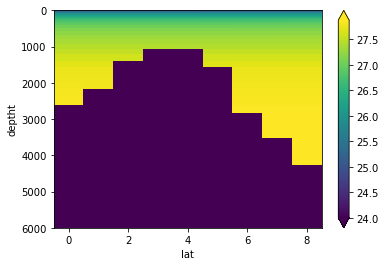

In [69]:
sigma.isel(lon=2).mean('time_counter').plot(vmin=24,vmax=27.87)
plt.gca().invert_yaxis()

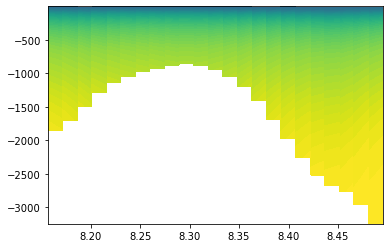

In [70]:
for i in [int(j) for j in np.linspace(0,len(Ewing_ROMS.isel(lat_rho=9).lon_rho)-2,int(len(Ewing_ROMS.isel(lat_rho=9).lon_rho-2)/2))]:
    cf = plt.contourf(Ewing_ROMS.isel(lat_rho=9).isel(slev=0).lon_rho[i:i+2],-Ewing_ROMS.isel(lat_rho=8).isel(lon_rho=i),sigma_ROMS.isel(lat=9,lon=slice(i,i+2)).mean('time'),levels=50,vmin=24,vmax=27.87)#,cmap=new_cmap)
for i in [int(j) for j in np.linspace(1,len(Ewing_ROMS.isel(lat_rho=9).lon_rho)-3,int(len(Ewing_ROMS.isel(lat_rho=9).lon_rho-2)/2)-1)]:
    cf = plt.contourf(Ewing_ROMS.isel(lat_rho=9).isel(slev=0).lon_rho[i:i+2],-Ewing_ROMS.isel(lat_rho=8).isel(lon_rho=i),sigma_ROMS.isel(lat=9,lon=slice(i,i+2)).mean('time'),levels=50,vmin=24,vmax=27.87)#,cmap=new_cmap)

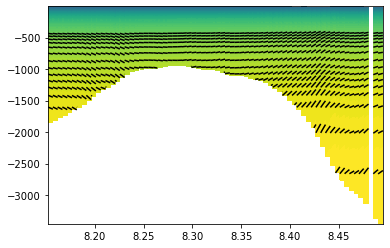

In [79]:
for i in [int(j) for j in np.linspace(0,len(Ewing_ROMSchild.isel(lat_rho=28).lon_rho)-2,int(len(Ewing_ROMSchild.isel(lat_rho=28).lon_rho-2)/2))]:
    cf = plt.contourf(Ewing_ROMSchild.isel(lat_rho=28).isel(slev=0).lon_rho[i:i+2],-Ewing_ROMSchild.isel(lat_rho=28).isel(lon_rho=i),sigma_ROMSchild.isel(lat=28,lon=slice(i,i+2)).mean('time'),levels=50,vmin=24,vmax=27.87)#,cmap=new_cmap)
    plt.contour(Ewing_ROMSchild.isel(lat_rho=28).isel(slev=0).lon_rho[i:i+2],-Ewing_ROMSchild.isel(lat_rho=28).isel(lon_rho=i),sigma_ROMSchild.isel(lat=28,lon=slice(i,i+2)).mean('time'),levels=np.linspace(27,27.87,15),colors='black')#,cmap=new_cmap)
for i in [int(j) for j in np.linspace(1,len(Ewing_ROMSchild.isel(lat_rho=28).lon_rho)-3,int(len(Ewing_ROMSchild.isel(lat_rho=28).lon_rho-2)/2)-1)]:
    cf = plt.contourf(Ewing_ROMSchild.isel(lat_rho=28).isel(slev=0).lon_rho[i:i+2],-Ewing_ROMSchild.isel(lat_rho=28).isel(lon_rho=i),sigma_ROMSchild.isel(lat=28,lon=slice(i,i+2)).mean('time'),levels=50,vmin=24,vmax=27.87)
    plt.contour(Ewing_ROMSchild.isel(lat_rho=28).isel(slev=0).lon_rho[i:i+2],-Ewing_ROMSchild.isel(lat_rho=28).isel(lon_rho=i),sigma_ROMSchild.isel(lat=28,lon=slice(i,i+2)).mean('time'),levels=np.linspace(27,27.87,15),colors='black')#,cmap=new_cmap)

In [106]:
image_paths = []

def plot_single_frame(time_index, save_path):
    global cbar
    fig, ax = plt.subplots()
    for i in [int(j) for j in np.linspace(0,len(Ewing_ROMSchild.isel(lat_rho=28).lon_rho)-2,int(len(Ewing_ROMSchild.isel(lat_rho=28).lon_rho-2)/2))]:
        cf = ax.contourf(Ewing_ROMSchild.isel(lat_rho=28).isel(slev=0).lon_rho[i:i+2],-Ewing_ROMSchild.isel(lat_rho=28).isel(lon_rho=i),sigma_ROMSchild.isel(lat=28,lon=slice(i,i+2),time=k),levels=50,vmin=24,vmax=27.87)#,cmap=new_cmap)
        ax.contour(Ewing_ROMSchild.isel(lat_rho=28).isel(slev=0).lon_rho[i:i+2],-Ewing_ROMSchild.isel(lat_rho=28).isel(lon_rho=i),sigma_ROMSchild.isel(lat=28,lon=slice(i,i+2),time=k),levels=np.linspace(27,27.87,15),colors='black')#,cmap=new_cmap)
    for i in [int(j) for j in np.linspace(1,len(Ewing_ROMSchild.isel(lat_rho=28).lon_rho)-3,int(len(Ewing_ROMSchild.isel(lat_rho=28).lon_rho-2)/2)-1)]:
        cf = ax.contourf(Ewing_ROMSchild.isel(lat_rho=28).isel(slev=0).lon_rho[i:i+2],-Ewing_ROMSchild.isel(lat_rho=28).isel(lon_rho=i),sigma_ROMSchild.isel(lat=28,lon=slice(i,i+2),time=k),levels=50,vmin=24,vmax=27.87)
        ax.contour(Ewing_ROMSchild.isel(lat_rho=28).isel(slev=0).lon_rho[i:i+2],-Ewing_ROMSchild.isel(lat_rho=28).isel(lon_rho=i),sigma_ROMSchild.isel(lat=28,lon=slice(i,i+2),time=k),levels=np.linspace(27,27.87,15),colors='black')#,cmap=new_cmap)
    
    temp_img_path = f'storage/image_{k:03d}.png'
    plt.savefig(temp_img_path)
    plt.close()
    
    image_paths.append(temp_img_path) 


100%|█████████████████████████████████████████| 365/365 [20:26<00:00,  3.36s/it]


In [113]:
output_gif = 'density.gif'
images = [Image.open(frame) for frame in image_paths]
images[0].save(
    output_gif,
    save_all=True,
    append_images=images[1:],
    duration=500 
)

#for frame in image_paths:
#    os.remove(frame)